In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import datetime
import itertools
import matplotlib.dates as mdates
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker




#### Figure aesthetics

In [2]:
#print(plt.style.available)
plt.style.use('seaborn-poster')
plt.style.use('seaborn-whitegrid')

#### Downlad data

In [3]:
def get_data():
    ##Get data from the source that is used to generate map (based on WHO official data):
    ##https://gisanddata.maps.arcgis.com/apps/opsdashboard/index.html?fbclid=IwAR0oKIKJlc-zeNZGFBVEN0-O-58daoCDaKicXwC10cjFWgCZqTPgavseTfI#/bda7594740fd40299423467b48e9ecf6
    url_confirmed = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"
    url_deaths = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv"
    url_recovered = "https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv"
    
    for url, data_type in zip([url_confirmed, url_deaths, url_recovered], ["confirmed", "deaths", "recovered"]):
    
        r = requests.get(url)
        filename=data_type+".csv"
        f = open(filename,'wb')
        f.write(r.content)

In [4]:
get_data()

#### Prepare dataset

In [5]:
## prepare dataset
confirmed = pd.read_csv("confirmed.csv")
deaths = pd.read_csv("deaths.csv")
recovered = pd.read_csv("recovered.csv")

def reshape_single_dataset(data):
    data=data.drop(columns=["Province/State", "Lat", "Long"])
    ## aggregate data for each country
    data=data.groupby("Country/Region").sum().reset_index()
    ## reshape data
    data.reset_index(drop=True, inplace=True)
    data=data.set_index("Country/Region")
    #data=data.transpose().reset_index().rename(columns={'index':'Date'})
    #data['Date'] = pd.to_datetime(data['Date'])
    
    return data

confirmed = reshape_single_dataset(confirmed)
deaths = reshape_single_dataset(deaths)
recovered = reshape_single_dataset(recovered)

In [6]:
inactive=deaths.add(recovered)
data=confirmed.subtract(inactive)
data=data.transpose().reset_index().rename(columns={'index':'Date'})
data['Date'] = pd.to_datetime(data['Date'])

#### List of countries in dataset

In [7]:
for el in data.columns:
    print(el)

Date
Afghanistan
Albania
Algeria
Andorra
Antigua and Barbuda
Argentina
Armenia
Aruba
Australia
Austria
Azerbaijan
Bahrain
Bangladesh
Belarus
Belgium
Bhutan
Bolivia
Bosnia and Herzegovina
Brazil
Brunei
Bulgaria
Burkina Faso
Cambodia
Cameroon
Canada
Cayman Islands
Chile
China
Colombia
Congo (Kinshasa)
Costa Rica
Cote d'Ivoire
Croatia
Cruise Ship
Cuba
Curacao
Cyprus
Czechia
Denmark
Dominican Republic
Ecuador
Egypt
Estonia
Eswatini
Ethiopia
Finland
France
French Guiana
Gabon
Georgia
Germany
Ghana
Greece
Guadeloupe
Guatemala
Guernsey
Guinea
Guyana
Holy See
Honduras
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jersey
Jordan
Kazakhstan
Kenya
Korea, South
Kuwait
Latvia
Lebanon
Liechtenstein
Lithuania
Luxembourg
Malaysia
Maldives
Malta
Martinique
Mauritania
Mexico
Moldova
Monaco
Mongolia
Morocco
Namibia
Nepal
Netherlands
New Zealand
Nigeria
North Macedonia
Norway
Oman
Pakistan
Panama
Paraguay
Peru
Philippines
Poland
Portugal
Qatar
Reunion
Romania
Russia
Rwanda
Sa

In [8]:

def exponent(x, a, b, c):
    return a * np.exp(b * (x-c))

def sigmoid(x, L , k, b, x0):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return y

#### Choose countries to plot (separate by ";" )

In [52]:
#countries_to_plot="Germany;France;Poland;Italy;Korea, South;United Kingdom".split(";")
#countries_to_plot="China".split(";")
countries_to_plot="Sweden;US;Germany".split(";")
#countries_to_plot="Poland;Germany".split(";")
countries_to_plot=[
    'Poland',
'Bosnia and Herzegovina',
 'Hungary',
# 'Liechtenstein',
 'Slovenia',
 'South Africa',
 'Tunisia']

#### Make plot

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52.]


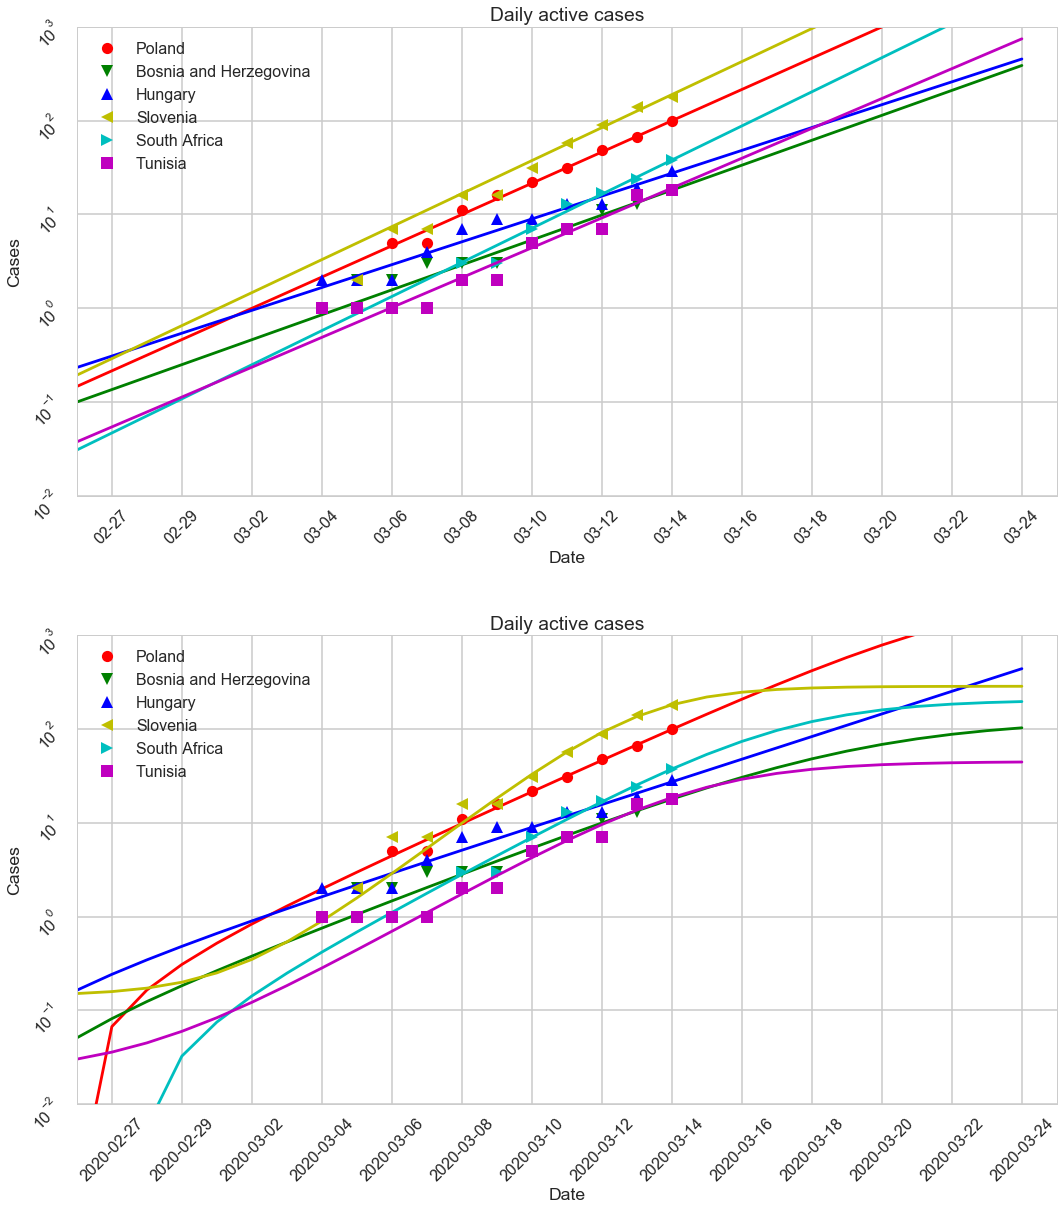

In [57]:
# extract data for each country, divide by population and multiply by the value of per_num
dates=data["Date"].values
dates_num = mdates.date2num(dates)
dates_start = np.min(dates_num)
dates_num = dates_num - dates_start

days_to_extrapolate=10
dates_num_extrapolate = np.arange(0,len(dates_num)+days_to_extrapolate,1)

print(dates_num)
countries=[]
fits=[]
sig_fits=[]

per_num=100000
for country in countries_to_plot:
    countries.append((data[country].values))
    #fit
    popt, pcov = curve_fit(exponent, dates_num, (data[country].values), maxfev=10000)
    sig_popt, sig_pcov = curve_fit(sigmoid, dates_num, (data[country].values),p0=[np.max(data[country].values),1,1,1],maxfev=10000)
    fits.append(exponent(dates_num_extrapolate, *popt))
    sig_fits.append(sigmoid(dates_num_extrapolate, *sig_popt))

## Create figure and plot space
fig, (ax, ax2) = plt.subplots(2,1, figsize=(16, 18), )

#Exponent fits
marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'p', 'P')) 
color = itertools.cycle(('r', 'g', 'b', 'y','c','m','k'))
## Add x-axis and y-axis
for country, fit, country_name in zip(countries, fits, countries_to_plot):
    col=next(color)
    ax.plot(dates, country, marker=next(marker), linestyle='', label=country_name, color=col)
    ax.plot(mdates.num2date(dates_num_extrapolate+dates_start), fit, color=col)
    
## Set title and labels for axes
ax.set(xlabel="Date",
       ylabel="Cases",
       title="Daily active cases")


#Sigmoidal fits
marker = itertools.cycle(('o', 'v', '^', '<', '>', 's', 'p', 'P')) 
color = itertools.cycle(('r', 'g', 'b', 'y','c','m','k'))
## Add x-axis and y-axis
for country, fit, country_name in zip(countries, sig_fits, countries_to_plot):
    col=next(color)
    ax2.plot(dates, country, marker=next(marker), linestyle='', label=country_name, color=col)
    ax2.plot(mdates.num2date(dates_num_extrapolate+dates_start), fit, color=col)
    
## Set title and labels for axes
ax2.set(xlabel="Date",
       ylabel="Cases",
       title="Daily active cases")

## Define the date format
for axis in [ax,ax2]:
    tick_spacing=2
    axis.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    axis.tick_params(labelrotation=45)


    date_form = DateFormatter("%m-%d")
    ax.xaxis.set_major_formatter(date_form)
    ## axes limits
    axis.set_xlim([datetime.date(2020, 2, 26), datetime.date.today() + datetime.timedelta(days=days_to_extrapolate)])# datetime.date(2020, 3, 15)])
    axis.set_ylim([10**-2,1000])
    axis.legend()
    
    axis.set_yscale("log")

fig.tight_layout(pad=5.0) 
plt.show()